In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import sys
import tensorflow as tf
import segmentation_models as sm
#from keras import backend as K
#K.set_image_data_format('channels_last')
from ImageDataAugmentor.image_data_augmentor import *
import albumentations
from datetime import datetime
print(tf.__version__)

1.14.0


In [2]:
!lscpu | grep "Model name"

Model name:                      Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz


In [3]:
def image_preprocessing(x):
    x = x/255. # rescale to [0,1]
    return(x)
    
TEST_AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5)
])

img_test_data_gen = ImageDataAugmentor(augment=TEST_AUGMENTATIONS, 
                                  augment_seed=123,
                                  preprocess_input = image_preprocessing)
img_test_gen = img_test_data_gen.flow_from_directory('./test_data/img', 
                                           class_mode=None, 
                                           shuffle=True, 
                                           seed=123, 
                                           color_mode='rgb', 
                                           target_size=(512, 512),
                                           batch_size=4)

Found 6812 images belonging to 1 classes.


In [4]:
def query(model):
    image_batch = next(img_test_gen)
    for i in range(4):
        start = datetime.now()
        pred = model.predict_on_batch(np.expand_dims(image_batch[i,:,:,:], axis=0))
        end = datetime.now()
        print(end - start)

In [24]:
from typing import List, Optional, NamedTuple
class Rectangle(NamedTuple):
    """Хранит координаты прямоугольника (xmin, ymin) - (xmax, ymax)"""

    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def w(self) -> int:
        """Ширина"""
        return self.xmax - self.xmin

    @property
    def h(self) -> int:
        """Высота"""
        return self.ymax - self.ymin

    @property
    def square(self) -> float:
        """Площадь"""
        return self.w * self.h


def image_grid(image_w: int, image_h: int,
               window_w: int, window_h: int,
               overlap_w: int, overlap_h: int) -> List[Rectangle]:
    """Рассчитывает координаты прямоугольников для разбиения изображения на блоки
    :param image_w: ширина изображения
    :param image_h: высота изображения
    :param window_w: ширина прямоугольника
    :param window_h: высота прямоугольника
    :param overlap_w: перекрытие прямоугольников по горизонтали
    :param overlap_h: перекрытие прямоугольников по вертикали
    """
    rectangles = []
    # комбинируем вертикальный и горизонтальные разрезы, чтобы получить прямоугольники
    for xmin in cut_points(image=image_w, window=window_w, overlap=overlap_w):
        for ymin in cut_points(image=image_h, window=window_h, overlap=overlap_h):
            rect = Rectangle(xmin=xmin, ymin=ymin, xmax=xmin + window_w, ymax=ymin + window_h)
            rectangles.append(rect)
    # избавляемся от повторов
    return list(set(rectangles))

def cut_points(image: int, window: int, overlap: int) -> List[int]:
    """Точки разрезов изображения (направляющие)"""
    points = []
    offset = window - overlap
    for v in range(0, image - window, offset):
        points.append(v)
    # справа и снизу остается неполный прямоугольник
    # добавим его, отсутпив справа ширину окна и сделаем еще один разрез
    points.append(image - window)
    return points

def count_crops(height_ori=3000, width_ori=4000, window_w: int = 416, window_h: int = 416, overlap_w: int = 150, overlap_h: int = 150):
    rects = image_grid(image_w=width_ori, image_h=height_ori,
                        window_w=window_w, window_h=window_w,
                        overlap_w=overlap_w, overlap_h=overlap_h)
    return rects

# Test performance on image 512*512

## U-Net (resnet18)

In [7]:
model = sm.Unet(backbone_name='resnet18',
    classes=1,
    encoder_weights='imagenet',
    input_shape=(512, 512, 3),
    encoder_freeze=True)
    
model.compile('Adam', 
              loss=sm.losses.binary_focal_dice_loss,
              metrics=[sm.metrics.iou_score, sm.metrics.f1_score])
query(model)

0:00:01.529350
0:00:00.477358
0:00:00.515232
0:00:00.518919


## U-Net (resnet34)

In [8]:
model = sm.Unet(backbone_name='resnet34',
    classes=1,
    encoder_weights='imagenet',
    input_shape=(512, 512, 3),
    encoder_freeze=True)

model.compile('Adam', 
              loss=sm.losses.binary_focal_dice_loss,
              metrics=[sm.metrics.iou_score, sm.metrics.f1_score])
query(model)

0:00:02.173203
0:00:00.558949
0:00:00.599785
0:00:00.569993


## U-Net (resnet50)

In [9]:
model = sm.Unet(backbone_name='resnet50',
    classes=1,
    encoder_weights='imagenet',
    input_shape=(512, 512, 3),
    encoder_freeze=True)

model.compile('Adam', 
              loss=sm.losses.binary_focal_dice_loss,
              metrics=[sm.metrics.iou_score, sm.metrics.f1_score])
query(model)

0:00:03.279154
0:00:00.973155
0:00:00.967939
0:00:00.890561


## U-Net (efn-B0)

In [10]:
model = sm.Unet(backbone_name='efficientnetb0',
    classes=1,
    encoder_weights='imagenet',
    input_shape=(512, 512, 3),
    encoder_freeze=True)

model.compile('Adam', 
              loss=sm.losses.binary_focal_dice_loss,
              metrics=[sm.metrics.iou_score, sm.metrics.f1_score])
query(model)

0:00:03.942730
0:00:00.778575
0:00:00.721337
0:00:00.747951


## U-Net (efn-B2)

In [11]:
model = sm.Unet(backbone_name='efficientnetb2',
    classes=1,
    encoder_weights='imagenet',
    input_shape=(512, 512, 3),
    encoder_freeze=True)

model.compile('Adam', 
              loss=sm.losses.binary_focal_dice_loss,
              metrics=[sm.metrics.iou_score, sm.metrics.f1_score])
query(model)

0:00:05.713695
0:00:00.978065
0:00:00.956792
0:00:00.970785


## U-Net (mobilenet-v1)

In [12]:
model = sm.Unet(backbone_name='mobilenet',
    classes=1,
    encoder_weights='imagenet',
    input_shape=(512, 512, 3),
    encoder_freeze=True)

model.compile('Adam', 
              loss=sm.losses.binary_focal_dice_loss,
              metrics=[sm.metrics.iou_score, sm.metrics.f1_score])
query(model)

/home/gosha20777/anaconda3/envs/tf-1-14/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


0:00:03.919622
0:00:00.656635
0:00:00.602401
0:00:00.575693


## U-Net (Custom-1)

In [13]:
from keras import Model
from keras.layers import Input, Dense, Concatenate, Convolution2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from keras.utils import Sequence
from keras.regularizers import l2

def model1(img_rows, img_cols, optimizer, reg=0.1):
    '''https://github.com/yihui-he/u-net'''
    inputs = Input(shape=(img_rows, img_cols, 3))
    bn1 = BatchNormalization()(inputs)
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(bn1)
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Convolution2D(512, (3, 3), activation='elu', padding='same')(pool4)
    conv5 = Convolution2D(512, (3, 3), activation='elu', padding='same')(conv5)
    up6 = Concatenate()([Convolution2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5)), conv4])
    conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv6)
    up7 = Concatenate()([Convolution2D(128, (2, 2),activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6)), conv3])
    conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv7)
    up8 = Concatenate()([Convolution2D(64, (2, 2),activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7)), conv2])
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv8)
    up9 = Concatenate()([Convolution2D(32, (2, 2),activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8)), conv1])
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv9)
    bn = BatchNormalization()(conv9)    
    conv10 = Convolution2D(1, (1, 1), activation='sigmoid')(bn)
    model = Model(inputs=inputs, outputs=conv10)
    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    print('U-Net compiled,  batch_norm1=True, batch_norm10=True, 4 skips.')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)
    return model

In [14]:
model = model1(512, 512, optimizer=Adam(learning_rate=1e-3))
query(model)

U-Net compiled,  batch_norm1=True, batch_norm10=True, 4 skips.
Input shape: (None, 512, 512, 3)
Output shape: (None, 512, 512, 1)
0:00:03.602837
0:00:00.623623
0:00:00.623829
0:00:00.640058


## Linknet (resnet18)

In [5]:
model = sm.Linknet(backbone_name='resnet18',
    classes=1,
    encoder_weights='imagenet',
    input_shape=(None, None, 3),
    encoder_freeze=True)

model.compile('Adam', 
              loss=sm.losses.binary_focal_dice_loss,
              metrics=[sm.metrics.iou_score, sm.metrics.f1_score])
query(model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
0:00:01.227597
0:00:00.246398
0:00:00.254326
0:00:00.257347


### Convert to tflite

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite = converter.convert()

with open("Linknet.tflite","wb") as h:
    h.write(tflite)

INFO:tensorflow:Assets written to: /tmp/tmp5tw66lel/assets


INFO:tensorflow:Assets written to: /tmp/tmp5tw66lel/assets


### int8 quanitization

In [22]:
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
def representative_data_gen():
    fimage = glob.glob('test_data/img/1/*.jpg')
    for input_value in range(10):
        if os.path.exists(fimage[input_value]):
            original_image=cv2.imread(fimage[input_value])
            image_data = cv2.resize(original_image, (512,512))
            image_data = preprocess_image(image_data)
            img_in = image_data[np.newaxis, ...].astype(np.float32)
            print("calibration image {}".format(fimage[input_value]))
            yield [img_in]
        else:
            continue
            

converter = tf.lite.TFLiteConverter.from_keras_model(model)

#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_ops = [
#    tf.lite.OpsSet.TFLITE_BUILTINS,
#    tf.lite.OpsSet.SELECT_TF_OPS
#]
#converter.allow_custom_ops = True
#converter.representative_dataset = representative_data_gen

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

tflite = converter.convert()

with open("model_int8.tflite","wb") as h:
    h.write(tflite)

INFO:tensorflow:Assets written to: /tmp/tmpqst0_2xg/assets


INFO:tensorflow:Assets written to: /tmp/tmpqst0_2xg/assets


calibration image test_data/img/1/146___p04982.jpg
calibration image test_data/img/1/256___p04096.jpg
calibration image test_data/img/1/77___n00110.jpg
calibration image test_data/img/1/50___p00978.jpg
calibration image test_data/img/1/32___n00341.jpg
calibration image test_data/img/1/18___n02883.jpg
calibration image test_data/img/1/329___p03688.jpg
calibration image test_data/img/1/46___p05597.jpg
calibration image test_data/img/1/296___p05680.jpg
calibration image test_data/img/1/385___p04509.jpg


### Inference

In [23]:
interpreter = tf.lite.Interpreter(model_path='model_int8.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'data', 'index': 0, 'shape': array([  1, 512, 512,   3], dtype=int32), 'shape_signature': array([ -1, 512, 512,   3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.006827473640442, -23), 'quantization_parameters': {'scales': array([1.0068275], dtype=float32), 'zero_points': array([-23], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 187, 'shape': array([1, 1, 1, 1], dtype=int32), 'shape_signature': array([-1, -1, -1,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [24]:
original_image = cv2.imread('test_data/img/1/0___n04759.jpg')
image_data = cv2.resize(original_image, (512,512))
image_data = preprocess_image(image_data)
#image_data = image_data / 255.
image_data = np.expand_dims(image_data, axis=0)
interpreter.allocate_tensors()

In [26]:
def set_input_tensor(interpreter, input):
    input_details = interpreter.get_input_details()[0]
    tensor_index = input_details['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    # Inputs for the TFLite model must be uint8, so we quantize our input data.
    # NOTE: This step is necessary only because we're receiving input data from
    # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
    # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
    #   input_tensor[:, :] = input
    scale, zero_point = input_details['quantization']
    input_tensor[:, :] = np.uint8(input / scale + zero_point)

start = datetime.now()
set_input_tensor(interpreter, image_data)
#interpreter.set_tensor(input_details[0]['index'], image_data)
interpreter.invoke()
pred = [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]
end = datetime.now()
print(end - start)

0:00:24.419191


### OpenVino

In [7]:
model.save('linknet_resnet_18.h5')

In [9]:
from tensorflow.keras import backend as K

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

K.set_learning_phase(0)    
    
weights_name = 'linknet_resnet_18.h5'

model = sm.Linknet(backbone_name='resnet18',
    classes=1,
    encoder_weights='imagenet',
    input_shape=(512, 512, 3),
    encoder_freeze=True)

model.load_weights(weights_name)
frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, '.', 'linknet_resnet_18.pb', as_text=False)
print(f'weights saved!')

INFO:tensorflow:Froze 519 variables.
INFO:tensorflow:Converted 519 variables to const ops.
weights saved!


In [16]:
!docker run -it --rm -v `pwd`:/lacmus --workdir /lacmus/ openvino/ubuntu18_dev:latest \
    bash -c "source /opt/intel/openvino_2020.4.287/bin/setupvars.sh && python3 inference_openvino.py --bin linknet_resnet_18_416.bin --xml linknet_resnet_18_416.xml --img test_data/img/1/0___n04761.jpg"

[setupvars.sh] OpenVINO environment initialized
initialize OpenVino...
[E:] [BSL] found 0 ioexpander device
E: [xLinkUsb] [    850384] [python3] usb_find_device_with_bcd:265	Library has not been initialized when loaded
available devices:  ['CPU', 'GNA']
loading model...
inference_openvino.py:86: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  net = IENetwork(model=model_xml, weights=model_bin)
inference_openvino.py:93: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  _, _, h, w = net.inputs[input_blob].shape
model input shape: [1, 3, 416, 416]
make 4 predictions:
	0.046399593353271484 s
	0.04608607292175293 s
	0.04748845100402832 s
	0.0509800910949707 s


In [17]:
!docker run -it --rm -v `pwd`:/lacmus --workdir /lacmus/ openvino/ubuntu18_dev:latest \
    bash -c "source /opt/intel/openvino_2020.4.287/bin/setupvars.sh && python3 inference_openvino.py --bin linknet_resnet_18_512.bin --xml linknet_resnet_18_512.xml --img test_data/img/1/0___n04761.jpg"

[setupvars.sh] OpenVINO environment initialized
initialize OpenVino...
[E:] [BSL] found 0 ioexpander device
E: [xLinkUsb] [    893910] [python3] usb_find_device_with_bcd:265	Library has not been initialized when loaded
available devices:  ['CPU', 'GNA']
loading model...
inference_openvino.py:86: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  net = IENetwork(model=model_xml, weights=model_bin)
inference_openvino.py:93: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  _, _, h, w = net.inputs[input_blob].shape
model input shape: [1, 3, 512, 512]
make 4 predictions:
	0.07027435302734375 s
	0.07549619674682617 s
	0.06219816207885742 s
	0.07791805267333984 s


In [22]:
!docker run -it --rm -v `pwd`:/lacmus --workdir /lacmus/ openvino/ubuntu18_dev:latest \
    bash -c "source /opt/intel/openvino_2020.4.287/bin/setupvars.sh && python3 inference_openvino.py --bin linknet_resnet_18_608.bin --xml linknet_resnet_18_608.xml --img test_data/img/1/0___n04761.jpg"

[setupvars.sh] OpenVINO environment initialized
initialize OpenVino...
[E:] [BSL] found 0 ioexpander device
E: [xLinkUsb] [    504376] [python3] usb_find_device_with_bcd:265	Library has not been initialized when loaded
available devices:  ['CPU', 'GNA']
loading model...
inference_openvino.py:86: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  net = IENetwork(model=model_xml, weights=model_bin)
inference_openvino.py:93: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  _, _, h, w = net.inputs[input_blob].shape
model input shape: [1, 3, 608, 608]
make 4 predictions:
	0.10514974594116211 s
	0.10730624198913574 s
	0.10131478309631348 s
	0.10210633277893066 s


In [34]:
!docker run -it --rm -v `pwd`:/lacmus --workdir /lacmus/ openvino/ubuntu18_dev:latest \
    bash -c "source /opt/intel/openvino_2020.4.287/bin/setupvars.sh && python3 inference_openvino.py --bin linknet_resnet_18_704.bin --xml linknet_resnet_18_704.xml --img test_data/img/1/0___n04761.jpg"

[setupvars.sh] OpenVINO environment initialized
initialize OpenVino...
[E:] [BSL] found 0 ioexpander device
E: [xLinkUsb] [    240756] [python3] usb_find_device_with_bcd:265	Library has not been initialized when loaded
available devices:  ['CPU', 'GNA']
loading model...
inference_openvino.py:86: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  net = IENetwork(model=model_xml, weights=model_bin)
inference_openvino.py:93: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  _, _, h, w = net.inputs[input_blob].shape
model input shape: [1, 3, 704, 704]
make 4 predictions:
	0.13303542137145996 s
	0.12978386878967285 s
	0.12861371040344238 s
	0.12896370887756348 s


In [18]:
!docker run -it --rm -v `pwd`:/lacmus --workdir /lacmus/ openvino/ubuntu18_dev:latest \
    bash -c "source /opt/intel/openvino_2020.4.287/bin/setupvars.sh && python3 inference_openvino.py --bin linknet_resnet_18_800.bin --xml linknet_resnet_18_800.xml --img test_data/img/1/0___n04761.jpg"

[setupvars.sh] OpenVINO environment initialized
initialize OpenVino...
[E:] [BSL] found 0 ioexpander device
E: [xLinkUsb] [    925243] [python3] usb_find_device_with_bcd:265	Library has not been initialized when loaded
available devices:  ['CPU', 'GNA']
loading model...
inference_openvino.py:86: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  net = IENetwork(model=model_xml, weights=model_bin)
inference_openvino.py:93: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  _, _, h, w = net.inputs[input_blob].shape
model input shape: [1, 3, 800, 800]
make 4 predictions:
	0.16902804374694824 s
	0.16206574440002441 s
	0.16184186935424805 s
	0.16449570655822754 s


In [19]:
!docker run -it --rm -v `pwd`:/lacmus --workdir /lacmus/ openvino/ubuntu18_dev:latest \
    bash -c "source /opt/intel/openvino_2020.4.287/bin/setupvars.sh && python3 inference_openvino.py --bin linknet_resnet_18_1024.bin --xml linknet_resnet_18_1024.xml --img test_data/img/1/0___n04761.jpg"

[setupvars.sh] OpenVINO environment initialized
initialize OpenVino...
[E:] [BSL] found 0 ioexpander device
E: [xLinkUsb] [    961720] [python3] usb_find_device_with_bcd:265	Library has not been initialized when loaded
available devices:  ['CPU', 'GNA']
loading model...
inference_openvino.py:86: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  net = IENetwork(model=model_xml, weights=model_bin)
inference_openvino.py:93: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  _, _, h, w = net.inputs[input_blob].shape
model input shape: [1, 3, 1024, 1024]
make 4 predictions:
	0.2740461826324463 s
	0.2689168453216553 s
	0.2706468105316162 s
	0.2675347328186035 s


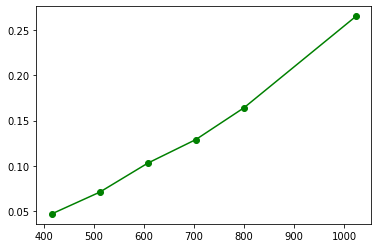

In [35]:
x = [416, 512, 608, 704, 800, 1024]
y = [0.047, 0.071, 0.103, 0.129, 0.164, 0.265]
plt.plot(x, y, marker="o", c="g")

In [36]:
count_416_full = len(count_crops(height_ori=3000, width_ori=4000,
                             window_w=416, window_h=416))
count_416_half = len(count_crops(height_ori=1500, width_ori=2000,
                             window_w=416, window_h=416))
count_512_full = len(count_crops(height_ori=3000, width_ori=4000,
                             window_w=512, window_h=512))
count_512_half = len(count_crops(height_ori=1500, width_ori=2000,
                             window_w=512, window_h=512))
count_608_full = len(count_crops(height_ori=3000, width_ori=4000,
                             window_w=608, window_h=608))
count_608_half = len(count_crops(height_ori=1500, width_ori=2000,
                             window_w=608, window_h=608))
count_704_full = len(count_crops(height_ori=3000, width_ori=4000,
                             window_w=704, window_h=704))
count_704_half = len(count_crops(height_ori=1500, width_ori=2000,
                             window_w=704, window_h=704))
count_800_full = len(count_crops(height_ori=3000, width_ori=4000,
                             window_w=800, window_h=800))
count_800_half = len(count_crops(height_ori=1500, width_ori=2000,
                             window_w=800, window_h=800))
count_1024_full = len(count_crops(height_ori=3000, width_ori=4000,
                             window_w=1024, window_h=1024))
count_1024_half = len(count_crops(height_ori=1500, width_ori=2000,
                             window_w=1024, window_h=1024))

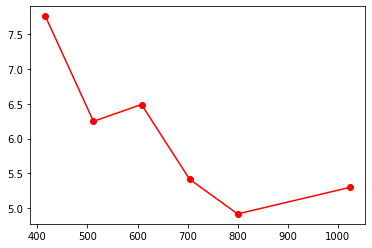

In [38]:
x = [416, 512, 608, 704, 800, 1024]
y = [0.047*count_416_full,
     0.071*count_512_full,
     0.103*count_608_full,
     0.129*count_704_full,
     0.164*count_800_full,
     0.265*count_1024_full]

plt.plot(x, y, marker="o", c="r")

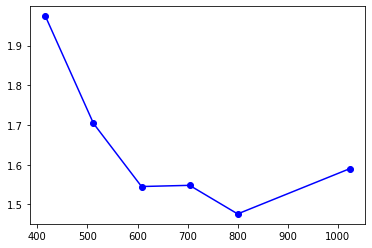

In [39]:
x = [416, 512, 608, 704, 800, 1024]
y = [0.047*count_416_half,
     0.071*count_512_half,
     0.103*count_608_half,
     0.129*count_704_half,
     0.164*count_800_half,
     0.265*count_1024_half]

plt.plot(x, y, marker="o", c="b")

In [42]:
time = len(count_crops(height_ori=1333, width_ori=800,
                             window_w=800, window_h=800))*0.164
print(f'{time}s vs 1s')

0.328s vs 1s


### Keras-Retinanet (resnet-50)

In [15]:
from keras_retinanet import models

def create_model(backbone_name, num_classes=1):
    backbone_factory = models.backbone(backbone_name)
    model = backbone_factory.retinanet(num_classes)
    return models.convert_model(model)

backbone = 'resnet50'
model = create_model(backbone)
query(model)

tracking <tf.Variable 'Variable_5:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_6:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_7:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_8:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_9:0' shape=(9, 4) dtype=float32> anchors
indices.shape[-1]: 1 <= params.rank: 2 and shape (?, 4)
indices.shape[-1]: 1 <= params.rank: 1 and shape (?,)
indices.shape[-1]: 2 <= params.rank: 2 and shape (?, 1)
0:00:03.942450
0:00:00.347900
0:00:00.343302
0:00:00.356467


In [21]:
backbone = 'EfficientNetB0'
model = create_model(backbone)
query(model)

tracking <tf.Variable 'Variable_10:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_11:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_12:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_13:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_14:0' shape=(9, 4) dtype=float32> anchors
indices.shape[-1]: 1 <= params.rank: 2 and shape (?, 4)
indices.shape[-1]: 1 <= params.rank: 1 and shape (?,)
indices.shape[-1]: 2 <= params.rank: 2 and shape (?, 1)
0:00:07.703907
0:00:00.541582
0:00:00.542402
0:00:00.551486


### Keras-Retinanet (mobilenet)

In [16]:
backbone = 'mobilenet224_0.1'
model = create_model(backbone)
query(model)

tracking <tf.Variable 'Variable_10:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_11:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_12:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_13:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_14:0' shape=(9, 4) dtype=float32> anchors
indices.shape[-1]: 1 <= params.rank: 2 and shape (?, 4)
indices.shape[-1]: 1 <= params.rank: 1 and shape (?,)
indices.shape[-1]: 2 <= params.rank: 2 and shape (?, 1)
0:00:03.493817
0:00:00.174082
0:00:00.245533
0:00:00.190339


### YOLO 4-tf (416*416)

In [15]:
!cd ../tensorflow-yolov4-tflite && \
   python detect.py --weights ./checkpoints/yolov4-416 \
   --size 416 --model yolov4 \
   --image ../lacmus-research/test_data/img/1/0___n04759.jpg

0:00:00.658849
0:00:00.255762
0:00:00.254708
0:00:00.265157


### YOLO 4-tf-tiny (416*416)

In [17]:
!cd ../tensorflow-yolov4-tflite && \
   python detect.py --weights ./checkpoints/yolov4-tiny-416 \
   --size 416 --model yolov4 \
   --image ../lacmus-research/test_data/img/1/0___n04759.jpg --tiny

0:00:00.142459
0:00:00.025333
0:00:00.028778
0:00:00.026272
